## Regression

In this lecture, I will show you how easy and practical is to engineer the features of a dataset utilising the new package feature engine and the scikit-learn pipeline.

**We use the Ames House Prices dataset produced by Professor Dean De Cock:**

Dean De Cock (2011) Ames, Iowa: Alternative to the Boston Housing
Data as an End of Semester Regression Project, Journal of Statistics Education, Vol.19, No. 3

http://jse.amstat.org/v19n3/decock.pdf

https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627

The version of the dataset used in this notebook can be obtained from [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

## House Prices dataset

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline as pipe
from sklearn.preprocessing import MinMaxScaler

from feature_engine import categorical_encoders as ce
from feature_engine import discretisers as dsc
from feature_engine import missing_data_imputers as mdi

pd.pandas.set_option('display.max_columns', None)

### Load Datasets

In [2]:
# load dataset
data = pd.read_csv('houseprice.csv')

# drop some variables
data.drop(labels=['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'Id'], axis=1, inplace=True)

print(data.shape)

data.head()

(1460, 77)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Make lists of variables

In [3]:
# categorical variables
categorical = [var for var in data.columns if data[var].dtype == 'O']

# make a list of all numerical variables first
numerical = [var for var in data.columns if data[var].dtype != 'O']

# discrete variables
discrete = [
    var for var in numerical
    if len(data[var].unique()) < 20
]

# continuous vars
numerical = [
    var for var in numerical if var not in discrete
    and var not in ['Id', 'SalePrice']
]

print('There are {} categorical variables'.format(len(categorical)))
print('There are {} discrete variables'.format(len(discrete)))
print('There are {} numerical and continuous variables'.format(len(numerical)))

There are 43 categorical variables
There are 15 discrete variables
There are 18 numerical and continuous variables


In [4]:
## the categorical encoders only work with categorical variables
# therefore we need to cast the discrete variables into categorical

data[discrete]= data[discrete].astype('O')

### Separate train and test set

In [5]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data.drop(labels=['SalePrice'], axis=1),
                                                    data.SalePrice,
                                                    test_size=0.1,
                                                    random_state=0)
X_train.shape, X_test.shape

((1314, 76), (146, 76))

### Feature engineering with feature engine and the sklearn pipeline

In [6]:
price_pipe = pipe([
    # add a binary variable to indicate missing information for the 2 variables below
    ('continuous_var_imputer', mdi.AddNaNBinaryImputer(variables = ['LotFrontage'])),
     
    # replace NA by the median in the 2 variables below, they are numerical
    ('continuous_var_median_imputer', mdi.MeanMedianImputer(imputation_method='median', variables = ['LotFrontage', 'MasVnrArea'])),
     
    # replace NA by adding the label "Missing" in categorical variables (transformer will skip those variables where there is no NA)
    ('categorical_imputer', mdi.CategoricalVariableImputer(variables = categorical)),
     
    # disretise numerical variables using trees
    ('numerical_tree_discretiser', dsc.DecisionTreeDiscretiser(cv = 3, scoring='neg_mean_squared_error', variables = numerical, regression=True)),
     
    # remove rare labels in categorical and discrete variables
    ('rare_label_encoder', ce.RareLabelCategoricalEncoder(tol = 0.03, n_categories=1, variables = categorical+discrete)),
     
    # encode categorical variables using the target mean 
    ('categorical_encoder', ce.MeanCategoricalEncoder(variables = categorical+discrete)),
    
    # scale features
    ('scaler', MinMaxScaler()),
    
    # Lasso
    ('lasso', Lasso(random_state=2909, alpha=0.005))
     ])

In [7]:
price_pipe.fit(X_train, np.log(y_train))

Pipeline(memory=None,
         steps=[('continuous_var_imputer',
                 AddNaNBinaryImputer(variables=['LotFrontage'])),
                ('continuous_var_median_imputer',
                 MeanMedianImputer(imputation_method='median',
                                   variables=['LotFrontage', 'MasVnrArea'])),
                ('categorical_imputer',
                 CategoricalVariableImputer(variables=['MSZoning', 'Street',
                                                       'Alley', 'LotShape',
                                                       'LandContour',
                                                       'Utilities', 'Lo...
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                      

In [8]:
pred_train = price_pipe.predict(X_train)
pred_test = price_pipe.predict(X_test)

In [9]:
np.exp(pred_train)

array([218634.44113657, 141507.05797664, 266140.66602427, ...,
       131965.67260611, 207938.46493215, 201090.07530011])

In [10]:
print('Lasso Linear Model train mse: {}'.format(mean_squared_error(y_train, np.exp(pred_train))))
print('Lasso Linear Model train rmse: {}'.format(sqrt(mean_squared_error(y_train, np.exp(pred_train)))))

print()
print('Lasso Linear Model test mse: {}'.format(mean_squared_error(y_test, np.exp(pred_test))))
print('Lasso Linear Model train rmse: {}'.format(sqrt(mean_squared_error(y_test, np.exp(pred_test)))))

Lasso Linear Model train mse: 949189263.8948538
Lasso Linear Model train rmse: 30808.9153313591

Lasso Linear Model test mse: 1344649485.0641894
Lasso Linear Model train rmse: 36669.46256852136


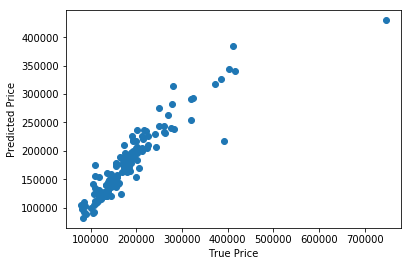

In [11]:
plt.scatter(y_test, np.exp(pred_test))
plt.xlabel('True Price')
plt.ylabel('Predicted Price')
plt.show()